Total text chunks: 503


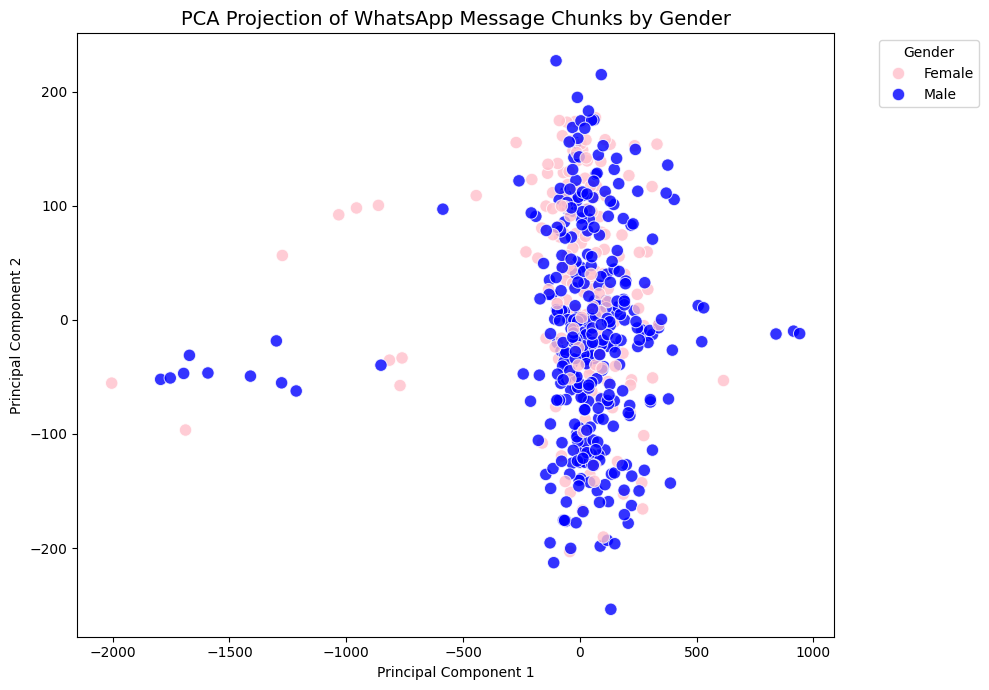

In [11]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
wa_df_all = pd.read_parquet(datafile)

# %%
# Filter messages based on keywords
wa_df = wa_df_all[wa_df_all["message"].str.contains(r"lift|camera|trap|ventilatie", case=False, na=False)]
wa_df.shape  # Check the filtered shape
wa_df.describe()

# %%
# Function to remove URLs from the messages
def remove_url(text):
    return re.sub(r"https?://\S+", "", text)

# Always work on a copy to avoid the warning
wa_df = wa_df.copy()

# Clean the message column
wa_df.loc[:, "message"] = (
    wa_df["message"]
    .astype(str)                   
    .str.replace("\n", " ", regex=False)  
    .apply(remove_url)             
    .str.lower()                   
)

wa_df.describe()

# %%
# Count message sizes
wa_df["size"] = wa_df["message"].apply(lambda x: len(str(x)))
wa_df["size"].describe()

# %%
# Chunking messages by author
n = 140  # chunk size
min_parts = 2  # minimum parts

authors = list(np.unique(wa_df.author))
corpus = {}

for author in authors:
    subset = wa_df[wa_df.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i : i + n] for i in range(0, len(longseq), n)]
    if len(parts) > min_parts:
        corpus[author] = parts

# %%
# Vectorization
all_parts = []
labels = []

for author, chunks in corpus.items():
    all_parts.extend(chunks)
    labels.extend([author] * len(chunks))

print(f"Total text chunks: {len(all_parts)}")

# Map author to selected metadata field
Label_residents_metadata = "Gender"  # Change as needed
age_map = dict(zip(author_info_df["author"], author_info_df[Label_residents_metadata]))

# Create a list of labels matching your text chunks
age_labels = [age_map.get(a, "Unknown") for a in labels]

# %%
# PCA Analysis
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
X = vectorizer.fit_transform(all_parts)
distance = manhattan_distances(X)

# PCA on the distance matrix
pca = PCA(n_components=2)
model = pca.fit_transform(distance)

# Build DataFrame for plotting
pca_df = pd.DataFrame(model, columns=["PC1", "PC2"])
pca_df[Label_residents_metadata] = age_labels

# Plotting
plt.figure(figsize=(10, 7))
palette = {
    "Male": "blue",
    "Female": "pink"
}

# Create scatter plot
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue=Label_residents_metadata,
    palette=palette,
    s=80,
    alpha=0.8
)

plt.title("PCA Projection of WhatsApp Message Chunks by Gender", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [12]:
# %%
# Analyze encircled regions (update ranges based on your PCA plot)
pc1_range_1 = (-50, 50)  # Update based on your PCA plot
pc2_range_1 = (-150, -100)

pc1_range_2 = (50, 100)  # Update based on your PCA plot
pc2_range_2 = (-100, 0)

# Filter messages in the first encircled area
encircled_1 = pca_df[
    (pca_df['PC1'].between(*pc1_range_1)) & 
    (pca_df['PC2'].between(*pc2_range_1))
]

# Filter messages in the second encircled area
encircled_2 = pca_df[
    (pca_df['PC1'].between(*pc1_range_2)) & 
    (pca_df['PC2'].between(*pc2_range_2))
]

# Get the authors for these encircled messages
authors_encircled_1 = encircled_1[Label_residents_metadata].unique()
authors_encircled_2 = encircled_2[Label_residents_metadata].unique()

# Extract messages from the original DataFrame
messages_encircled_1 = wa_df[wa_df['author'].isin(authors_encircled_1)]
messages_encircled_2 = wa_df[wa_df['author'].isin(authors_encircled_2)]

# Count keywords in the filtered messages
keywords = ['lift', 'camera', 'trap', 'ventilatie']

def count_keywords(messages, keywords):
    keyword_counts = {keyword: 0 for keyword in keywords}
    for message in messages['message']:
        for keyword in keywords:
            keyword_counts[keyword] += message.lower().count(keyword)
    return keyword_counts

counts_encircled_1 = count_keywords(messages_encircled_1, keywords)
counts_encircled_2 = count_keywords(messages_encircled_2, keywords)

print("Keyword counts in Encircled Region 1:", counts_encircled_1)
print("Keyword counts in Encircled Region 2:", counts_encircled_2)

Keyword counts in Encircled Region 1: {'lift': 0, 'camera': 0, 'trap': 0, 'ventilatie': 0}
Keyword counts in Encircled Region 2: {'lift': 0, 'camera': 0, 'trap': 0, 'ventilatie': 0}


2025-11-08 09:32:32.230 | INFO     | __main__:<module>:35 - Loaded WhatsApp dataset: 4565 messages
2025-11-08 09:32:32.302 | INFO     | __main__:<module>:53 - 558 messages contain a question mark
2025-11-08 09:32:32.311 | INFO     | __main__:<module>:61 - Aggregated text per author: 57 authors
2025-11-08 09:32:32.375 | INFO     | __main__:<module>:66 - Trigram feature matrix shape: (57, 5547)
/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_92526/1087940634.py:92: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


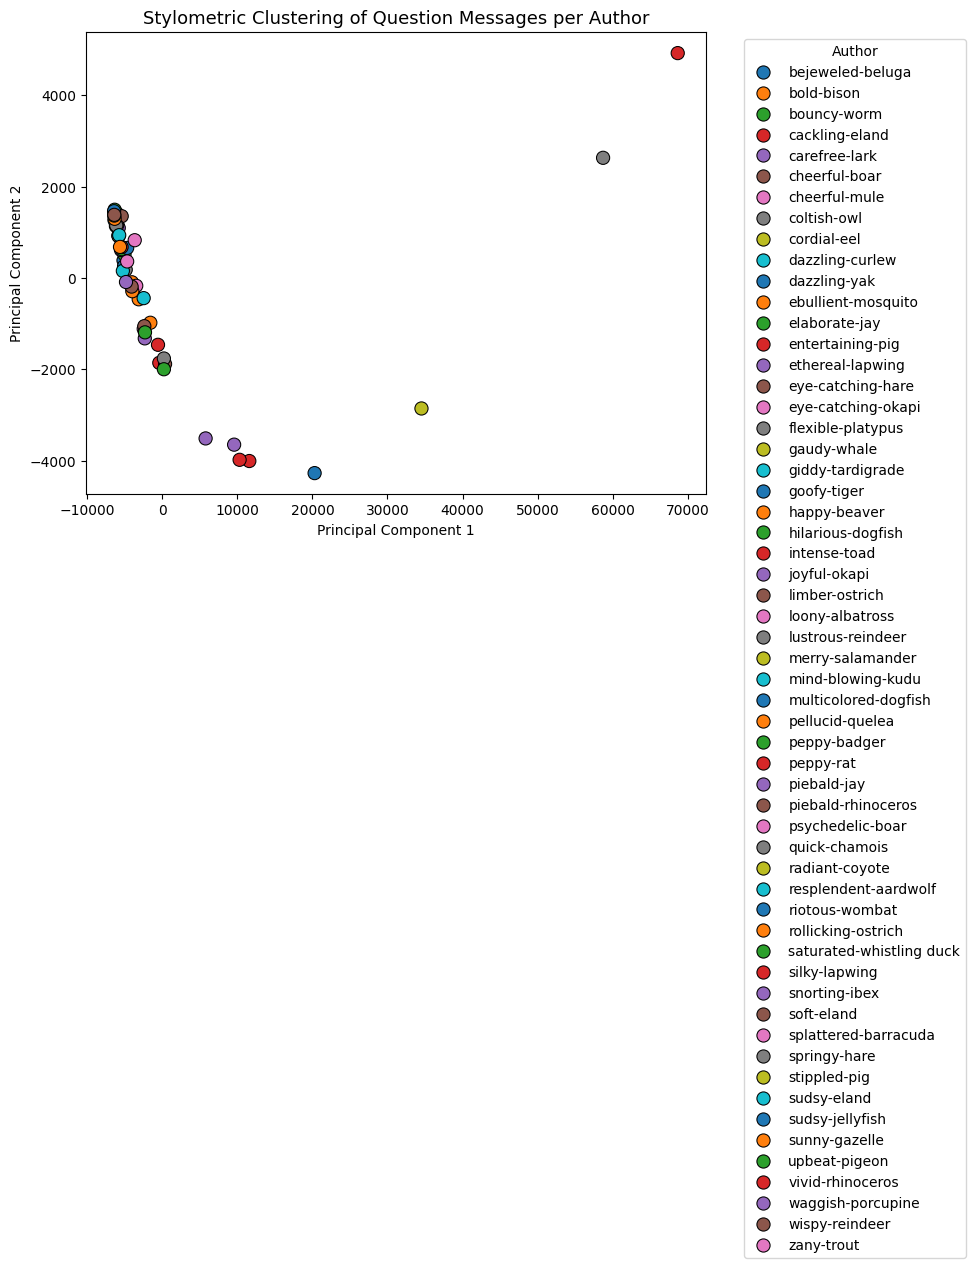

/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_92526/1087940634.py:97: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance, method="ward")


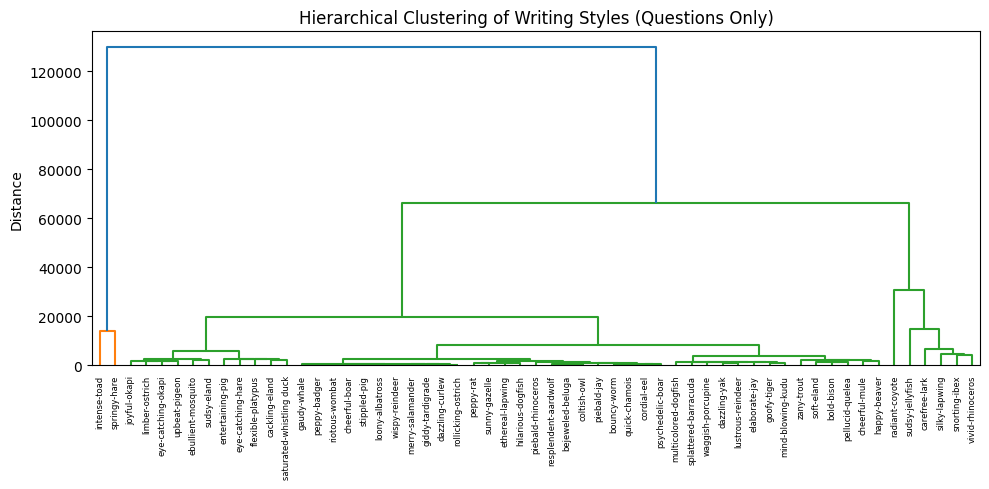

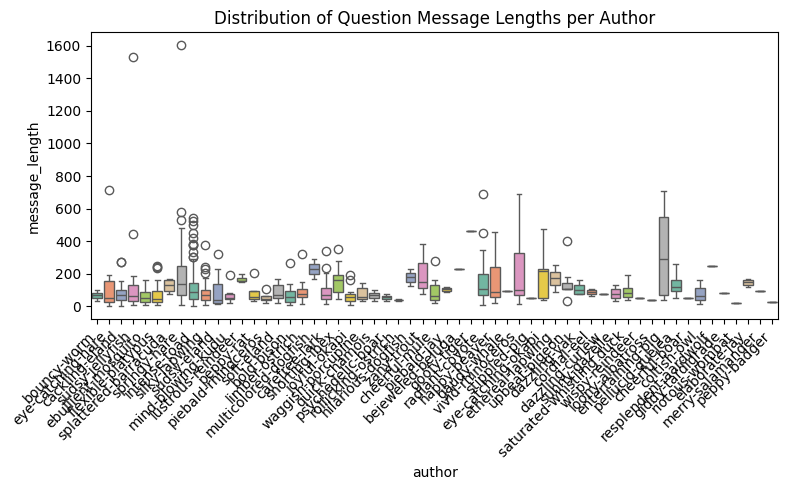

2025-11-08 09:32:36.198 | INFO     | __main__:<module>:127 - Summary statistics per author:


                      author  total_questions  avg_length  has_emoji_ratio
0           bejeweled-beluga                1  227.000000         0.000000
1                 bold-bison                8   83.125000         0.125000
2                bouncy-worm                2   67.000000         0.000000
3             cackling-eland               15   93.066667         0.000000
4              carefree-lark               26   91.961538         0.038462
5              cheerful-boar                1   50.000000         0.000000
6              cheerful-mule                8   96.875000         0.125000
7                coltish-owl                3   81.000000         0.000000
8                cordial-eel                2   87.500000         0.000000
9            dazzling-curlew                1   77.000000         0.000000
10              dazzling-yak                4  108.750000         0.750000
11        ebullient-mosquito               18   62.888889         0.055556
12             elaborate-

In [13]:
# %%
"""
Stylometric Analysis of WhatsApp Messages in Apartment Group
------------------------------------------------------------
This script analyzes writing patterns and message distributions per author.
It follows a similar approach to the QAnon stylometric study, but adapted for chat data.
"""

# %% Imports
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from loguru import logger
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# %% Load dataset
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. Run src/preprocess.py first!")

wa_df_all = pd.read_parquet(datafile)
logger.info(f"Loaded WhatsApp dataset: {wa_df_all.shape[0]} messages")

# %% Clean text
def clean_message(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)  # remove links
    text = text.replace("\n", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

wa_df_all["clean_text"] = wa_df_all["message"].apply(clean_message)
wa_df_all = wa_df_all[wa_df_all["clean_text"].str.len() > 0]

# %% Identify question messages
wa_df_all["is_question"] = wa_df_all["clean_text"].str.contains(r"\?")

# %% Filter only question messages (if analysis focuses on those)
wa_q = wa_df_all[wa_df_all["is_question"]].copy()
logger.info(f"{wa_q.shape[0]} messages contain a question mark")

# %% Group messages per author and concatenate text
author_texts = (
    wa_q.groupby("author")["clean_text"]
    .apply(lambda x: " ".join(x))
    .reset_index()
)
logger.info(f"Aggregated text per author: {author_texts.shape[0]} authors")

# %% Create trigram-based stylometric vectors
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
X = vectorizer.fit_transform(author_texts["clean_text"])
logger.info(f"Trigram feature matrix shape: {X.shape}")

# %% Compute pairwise Manhattan distances
distance = manhattan_distances(X, X)

# %% PCA for visualization
pca = PCA(n_components=2)
coords = pca.fit_transform(distance)
author_texts["x"] = coords[:, 0]
author_texts["y"] = coords[:, 1]

# %% Scatterplot: writing-style clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=author_texts,
    x="x",
    y="y",
    hue="author",
    palette="tab10",
    s=90,
    edgecolor="black",
)
plt.title("Stylometric Clustering of Question Messages per Author", fontsize=13)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# %% Hierarchical clustering dendrogram
plt.figure(figsize=(10, 5))
linkage_matrix = linkage(distance, method="ward")
dendrogram(linkage_matrix, labels=author_texts["author"].values)
plt.title("Hierarchical Clustering of Writing Styles (Questions Only)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# %% Optional: Compare average question lengths per author
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=wa_q,
    x="author",
    y="message_length",
    palette="Set2"
)
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Question Message Lengths per Author")
plt.tight_layout()
plt.show()

# %% Save summary table
summary = (
    wa_q.groupby("author")
    .agg(
        total_questions=("is_question", "sum"),
        avg_length=("message_length", "mean"),
        has_emoji_ratio=("has_emoji", "mean"),
    )
    .reset_index()
)
logger.info("Summary statistics per author:")
print(summary)

summary.to_csv("whatsapp_question_summary.csv", index=False)


2025-11-08 09:32:36.250 | INFO     | __main__:<module>:37 - Loaded WhatsApp dataset: 4565 messages
2025-11-08 09:32:36.321 | INFO     | __main__:<module>:55 - 558 messages contain a question mark
2025-11-08 09:32:36.325 | INFO     | __main__:<module>:63 - Aggregated text per author: 57 authors
2025-11-08 09:32:36.390 | INFO     | __main__:<module>:68 - Trigram feature matrix shape: (57, 5547)
/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_92526/1563301475.py:94: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


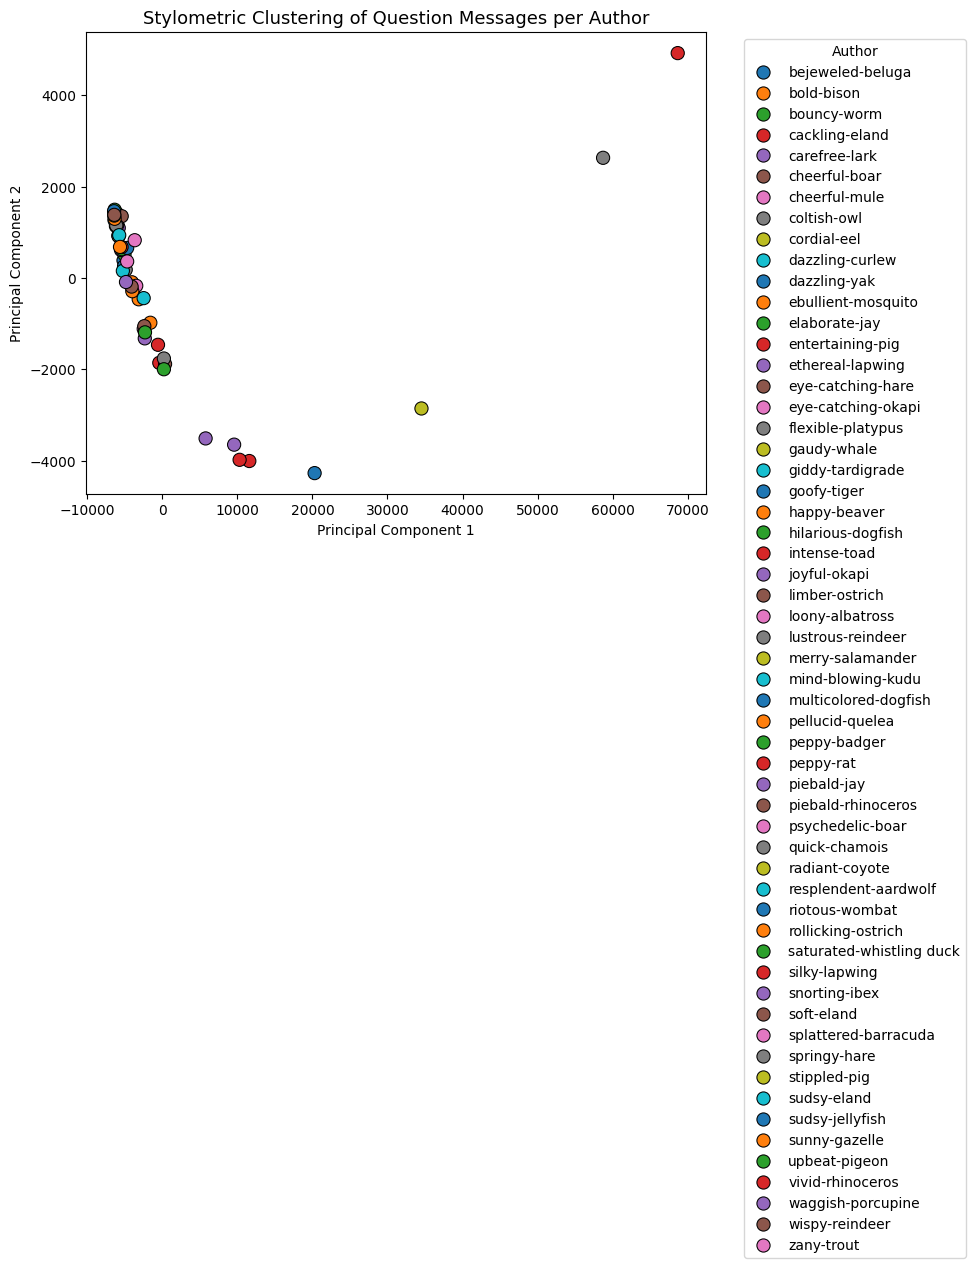

/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_92526/1563301475.py:99: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance, method="ward")


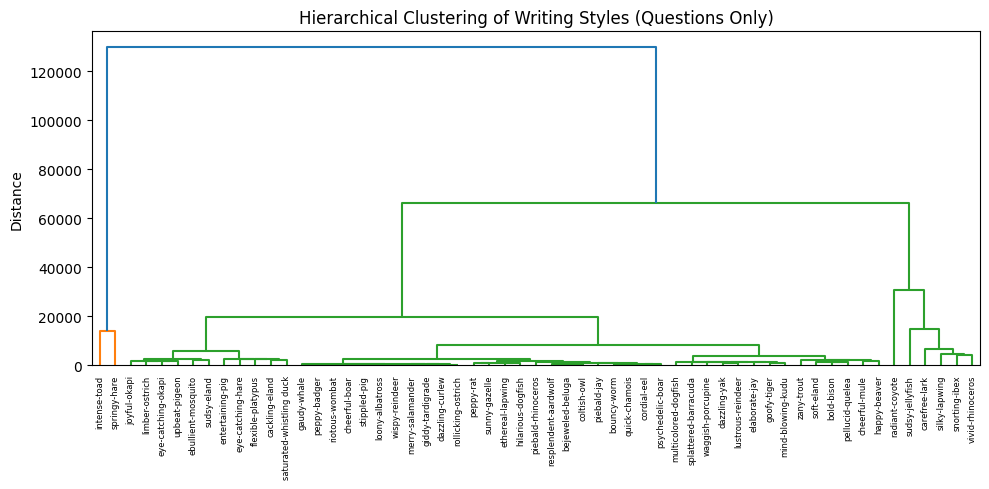

=== Authors in this cluster ===
              author             x            y
4      carefree-lark   5781.424461 -3510.225753
43     silky-lapwing  11600.761720 -4004.950949
44     snorting-ibex   9578.636405 -3646.523929
53  vivid-rhinoceros  10310.089447 -3978.456497

Sample messages from authors in this region (n=10):

--- carefree-lark ---
• hoe weet je waar/ op welke verdieping de monteur bezig is? lijkt me niet handig als je n/h werk moet
• maar de wethouder is toch eindverantwoordelijke? hij is dus schuldig.
• ik werk. wie wil voor me tekenen? ik ben voor het behoud van de bomen
• als de conclusie is dat het niet a/d flat ligt, moet de bewoner die de zaak heeft aangespannen toch alles betalen?
• is dit in ons flatgebouw? 😡
• wat is de oorzaak? en zoals joan schrijft: wat doe je met de producten in de vriezer?
• was het eenmalig?
• terrible. was it locked? you should make a complaint at the police station.
• als het ruim onder de norm ligt, kan de zaak toch afgesloten worden?
•

/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_92526/1563301475.py:161: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


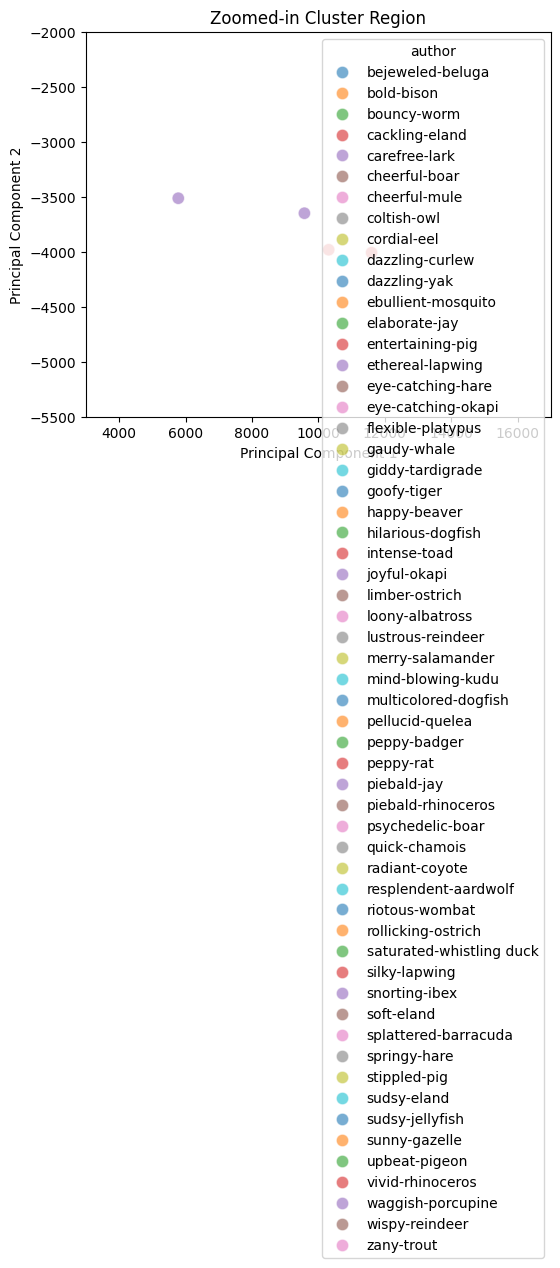


Cluster summary saved to cluster_summary.csv


In [14]:
# %%
"""
Stylometric Analysis of WhatsApp Messages (Questions Only)
----------------------------------------------------------
This script analyzes writing patterns of residents in an apartment group
using character trigram stylometry. It also allows you to inspect specific
clusters (regions) in the PCA visualization to see which authors are grouped
together and what kind of messages they write.
"""

# %% Imports
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from loguru import logger
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# %% Load dataset
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. Run src/preprocess.py first!")

wa_df_all = pd.read_parquet(datafile)
logger.info(f"Loaded WhatsApp dataset: {wa_df_all.shape[0]} messages")

# %% Clean text
def clean_message(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)  # remove links
    text = text.replace("\n", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

wa_df_all["clean_text"] = wa_df_all["message"].apply(clean_message)
wa_df_all = wa_df_all[wa_df_all["clean_text"].str.len() > 0]

# %% Identify question messages
wa_df_all["is_question"] = wa_df_all["clean_text"].str.contains(r"\?")

# %% Filter only question messages
wa_q = wa_df_all[wa_df_all["is_question"]].copy()
logger.info(f"{wa_q.shape[0]} messages contain a question mark")

# %% Group messages per author and concatenate text
author_texts = (
    wa_q.groupby("author")["clean_text"]
    .apply(lambda x: " ".join(x))
    .reset_index()
)
logger.info(f"Aggregated text per author: {author_texts.shape[0]} authors")

# %% Create trigram-based stylometric vectors
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
X = vectorizer.fit_transform(author_texts["clean_text"])
logger.info(f"Trigram feature matrix shape: {X.shape}")

# %% Compute pairwise Manhattan distances
distance = manhattan_distances(X, X)

# %% PCA for visualization
pca = PCA(n_components=2)
coords = pca.fit_transform(distance)
author_texts["x"] = coords[:, 0]
author_texts["y"] = coords[:, 1]

# %% Scatterplot: writing-style clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=author_texts,
    x="x",
    y="y",
    hue="author",
    palette="tab10",
    s=90,
    edgecolor="black",
)
plt.title("Stylometric Clustering of Question Messages per Author", fontsize=13)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# %% Hierarchical clustering dendrogram
plt.figure(figsize=(10, 5))
linkage_matrix = linkage(distance, method="ward")
dendrogram(linkage_matrix, labels=author_texts["author"].values)
plt.title("Hierarchical Clustering of Writing Styles (Questions Only)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# %% Function to inspect clusters
def inspect_cluster(df_authors, df_messages, xmin, xmax, ymin, ymax, sample_n=10):
    """
    Selects authors and messages from a PCA region.

    Parameters:
    - df_authors: DataFrame with ['author', 'x', 'y']
    - df_messages: Original question-level DataFrame (wa_q)
    - xmin, xmax, ymin, ymax: coordinate range of cluster
    - sample_n: number of random messages to preview per author

    Returns:
    - cluster_authors_df: authors within coordinate range
    """
    cluster_authors_df = df_authors[
        (df_authors["x"] > xmin) & (df_authors["x"] < xmax)
        & (df_authors["y"] > ymin) & (df_authors["y"] < ymax)
    ].copy()

    if cluster_authors_df.empty:
        logger.warning("No authors found in this coordinate range.")
        return None

    print("=== Authors in this cluster ===")
    print(cluster_authors_df[["author", "x", "y"]])
    print("================================")

    selected_authors = cluster_authors_df["author"].tolist()
    subset = df_messages[df_messages["author"].isin(selected_authors)]

    print(f"\nSample messages from authors in this region (n={sample_n}):")
    for auth in selected_authors:
        print(f"\n--- {auth} ---")
        sample_msgs = subset[subset["author"] == auth]["clean_text"].sample(
            min(sample_n, len(subset[subset["author"] == auth])), random_state=42
        )
        for msg in sample_msgs:
            print(f"• {msg}")

    # Optional zoomed-in scatterplot
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=df_authors,
        x="x",
        y="y",
        hue="author",
        alpha=0.6,
        palette="tab10",
        s=80,
    )
    plt.xlim(xmin - 2000, xmax + 2000)
    plt.ylim(ymin - 1000, ymax + 1000)
    plt.title("Zoomed-in Cluster Region")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.tight_layout()
    plt.show()

    return cluster_authors_df

# %% Example: Inspect the encircled cluster (adjust as needed)
# Based on your image: roughly x = 5k–15k, y = –4500 to –3000
cluster_df = inspect_cluster(author_texts, wa_q, xmin=5000, xmax=15000, ymin=-4500, ymax=-3000)

# %% Save summary statistics for the cluster
if cluster_df is not None and not cluster_df.empty:
    selected_authors = cluster_df["author"].tolist()
    cluster_summary = (
        wa_q[wa_q["author"].isin(selected_authors)]
        .groupby("author")
        .agg(
            total_questions=("is_question", "sum"),
            avg_length=("message_length", "mean"),
            emoji_ratio=("has_emoji", "mean"),
        )
        .reset_index()
    )
    cluster_summary.to_csv("cluster_summary.csv", index=False)
    print("\nCluster summary saved to cluster_summary.csv")


In [15]:
# %% Imports
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from loguru import logger
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# %% Load dataset
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. Run src/preprocess.py first!")

wa_df_all = pd.read_parquet(datafile)
logger.info(f"Loaded WhatsApp dataset: {wa_df_all.shape[0]} messages")

# Select features for PCA
features = wa_df_all[['message_length', 'has_emoji', 'has_link', 'hour']]
# Optionally, you can add more features that are numerical

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(scaled_features)

# Creating a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['author'] = df['author']

# Plotting the PCA results
plt.figure(figsize=(10, 7))
for author in pca_df['author'].unique():
    plt.scatter(pca_df[pca_df['author'] == author]['Principal Component 1'], 
                pca_df[pca_df['author'] == author]['Principal Component 2'], 
                label=author)
    
plt.title('PCA of WhatsApp Message Dataset by Author')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

2025-11-08 09:32:38.880 | INFO     | __main__:<module>:27 - Loaded WhatsApp dataset: 4565 messages


TypeError: float() argument must be a string or a real number, not 'datetime.time'

In [ ]:
# %% Imports
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from loguru import logger
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

# %% Load dataset
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. Run src/preprocess.py first!")

wa_df_all = pd.read_parquet(datafile)
logger.info(f"Loaded WhatsApp dataset: {wa_df_all.shape[0]} messages")

# Convert 'hour' to numeric if it's in datetime.time format
if pd.api.types.is_datetime64_any_dtype(wa_df_all['hour']):
    wa_df_all['hour'] = wa_df_all['hour'].dt.hour  # Convert to hour as integer
else:
    # If it's a string representation, convert to numeric
    wa_df_all['hour'] = pd.to_numeric(wa_df_all['hour'], errors='coerce')

# Select features for PCA
features = wa_df_all[['message_length', 'has_emoji', 'has_link', 'hour']]

# Check data types of selected features
print("Data Types Before Conversion:")
print(features.dtypes)

# Ensure all features are numeric
features = features.apply(pd.to_numeric, errors='coerce')

# Print the DataFrame after coercion
print("Features DataFrame After Coercion:")
print(features)

# Check for any remaining non-numeric values
print("Number of NaNs in Each Column:")
print(features.isnull().sum())

# Drop rows with NaN values (if any)
features = features.dropna()

# Check if the features DataFrame is empty after dropping NaNs
if features.empty:
    logger.error("The features DataFrame is empty after dropping NaN values.")
    raise ValueError("No valid data available for PCA. Please check the input data.")

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(scaled_features)

# Creating a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['author'] = wa_df_all['author'].reindex(pca_df.index)  # Align authors with PCA results

# Plotting the PCA results
plt.figure(figsize=(10, 7))
for author in pca_df['author'].unique():
    plt.scatter(pca_df[pca_df['author'] == author]['Principal Component 1'], 
                pca_df[pca_df['author'] == author]['Principal Component 2'], 
                label=author)
    
plt.title('PCA of WhatsApp Message Dataset by Author')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

2025-11-06 00:52:36.629 | INFO     | __main__:<module>:27 - Loaded WhatsApp dataset: 4565 messages
2025-11-06 00:52:36.642 | ERROR    | __main__:<module>:59 - The features DataFrame is empty after dropping NaN values.


Data Types Before Conversion:
message_length      int64
has_emoji            bool
has_link             bool
hour              float64
dtype: object
Features DataFrame After Coercion:
      message_length  has_emoji  has_link  hour
0                 26      False     False   NaN
1                 87      False     False   NaN
2                 31      False     False   NaN
3                 40      False     False   NaN
4                 19       True     False   NaN
...              ...        ...       ...   ...
4560              41       True     False   NaN
4561               1       True     False   NaN
4562               1       True     False   NaN
4563             300      False     False   NaN
4564              78       True     False   NaN

[4565 rows x 4 columns]
Number of NaNs in Each Column:
message_length       0
has_emoji            0
has_link             0
hour              4565
dtype: int64


ValueError: No valid data available for PCA. Please check the input data.